In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from helper_functions import download_data
from compile_engine import train
from data_setup import create_dataloaders
from utils import save_model
import pandas as pd
from timeit import default_timer as timer
import random

from PIL import Image

2.6.0+cu124 True


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
effnetb2_weights = models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms
effnetb2 = models.efficientnet_b2(effnetb2_weights)
manual_transform = transforms.Compose(
    [
        transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)

/home/harish/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [4]:
compiled_model = torch.compile(effnetb2)

In [5]:
data_path = Path("data/pizza_steak_sushi_20_percent/")
train_dir = data_path/"train"
test_dir = data_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [6]:
train_dataloader,test_dataloader,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)

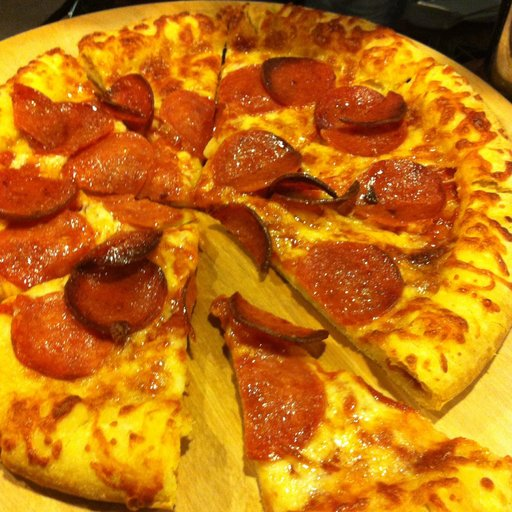

In [7]:
test_image_dir = list(Path(test_dir).glob("*/*.jpg"))
random_image = Image.open(random.sample(test_image_dir,k=1)[0])
random_image

In [8]:
optimizer = torch.optim.Adam(
    params=effnetb2.parameters(),
    lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()

In [9]:
effnetb2.to(device=device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
normal_results=train(effnetb2,train_dataloader,test_dataloader,optimizer,loss_fn,epochs=5,device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1936 | train_acc: 0.6542 | test_loss: 0.9173 | test_acc: 0.8187 | train_epoch_time: 3.1820 | test_epoch_time: 0.4356


Training Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.4265 | train_acc: 0.8354 | test_loss: 0.5425 | test_acc: 0.8938 | train_epoch_time: 2.7561 | test_epoch_time: 0.4415


Training Epoch 2:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3545 | train_acc: 0.8708 | test_loss: 0.4475 | test_acc: 0.8830 | train_epoch_time: 2.7457 | test_epoch_time: 0.4308


Training Epoch 3:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.5087 | train_acc: 0.9083 | test_loss: 0.4721 | test_acc: 0.8608 | train_epoch_time: 2.7695 | test_epoch_time: 0.4355


Training Epoch 4:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2542 | train_acc: 0.9354 | test_loss: 0.5168 | test_acc: 0.8642 | train_epoch_time: 2.7465 | test_epoch_time: 0.4269


In [14]:
torch.backends.cuda.matmul.allow_tf32 = True

In [15]:
compiled_results=train(compiled_model,train_dataloader,test_dataloader,optimizer,loss_fn,epochs=5,device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5651 | train_acc: 0.8646 | test_loss: 0.5563 | test_acc: 0.7972 | train_epoch_time: 56.7694 | test_epoch_time: 11.1462


Training Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1842 | train_acc: 0.9521 | test_loss: 0.5299 | test_acc: 0.8739 | train_epoch_time: 2.2160 | test_epoch_time: 0.4277


Training Epoch 2:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.0718 | train_acc: 0.9500 | test_loss: 0.2960 | test_acc: 0.9074 | train_epoch_time: 2.4187 | test_epoch_time: 0.4635


Training Epoch 3:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2657 | train_acc: 0.9479 | test_loss: 0.3144 | test_acc: 0.9097 | train_epoch_time: 2.1423 | test_epoch_time: 0.4433


Training Epoch 4:   0%|          | 0/15 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0986 | train_acc: 0.9646 | test_loss: 0.2086 | test_acc: 0.9381 | train_epoch_time: 2.2843 | test_epoch_time: 0.4780


In [ ]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 2.455 GB
Total GPU memory: 8.318 GB
